In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
sz = 224 # image size

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
ls {PATH}

models/  sample/  test1/  train/  valid/


In [7]:
ls {PATH}valid

cats/  dogs/


In [8]:
files = !ls {PATH}valid/cats | head

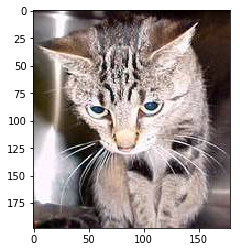

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [10]:
img.shape, img[:2,:2]

((198, 179, 3), array([[[29, 20, 23],
         [31, 22, 25]],
 
        [[60, 51, 54],
         [58, 49, 52]]], dtype=uint8))

## Step 1

In [11]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
#learn.fit(0.01,3)

100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


## step 2

In [12]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 303/360 [00:01<00:00, 153.42it/s, loss=0.438]


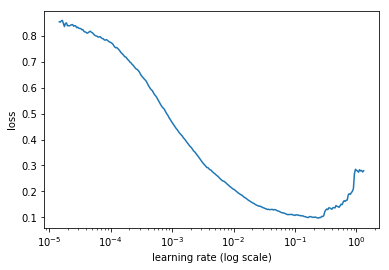

In [13]:
learn.sched.plot()

## step 3

In [14]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.054254   0.03101    0.990723  
    1      0.043003   0.025994   0.989746  



[0.025994286, 0.98974609375]

## step 4

In [15]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [16]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [17]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn.set_data(data, precompute=False)

In [19]:
% time learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.035119   0.027566   0.989746  
    1      0.027622   0.026498   0.990234  
    2      0.028523   0.025973   0.990723  

CPU times: user 6.97 s, sys: 3.53 s, total: 10.5 s
Wall time: 6.6 s


[0.025972702, 0.99072265625]

In [20]:
learn.save('session1-224_lastlayer')

In [21]:
learn.load('session1-224_lastlayer')

## step 5

In [22]:
learn.unfreeze()

## step 6

In [23]:
lr = np.array([1e-4, 1e-3, 1e-2])

## step 7

In [22]:
lrf2 = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 274/360 [01:24<00:26,  3.25it/s, loss=0.103] 

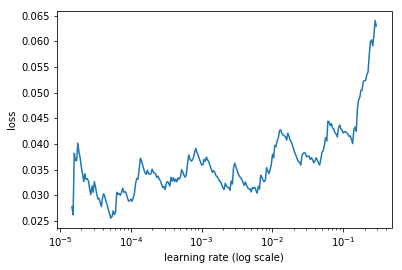

In [23]:
learn.sched.plot()

## step 8

In [25]:
% time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.034362   0.026923   0.990723  
    1      0.039713   0.028141   0.989258  
    2      0.029123   0.025676   0.989258  
    3      0.038625   0.027229   0.988281  
    4      0.030842   0.028063   0.990234  
    5      0.041487   0.027374   0.989258  
    6      0.033503   0.027071   0.989258  

CPU times: user 1h 17min 16s, sys: 1h 51min 32s, total: 3h 8min 48s
Wall time: 24min 28s


[0.027071197, 0.9892578125]

In [27]:
log_preds, y =learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs,y)

0.9925